# **Stage 5: Combined Augmentation Models for Hubert Speech Emotion Recognition**

#### **Overview**
This notebook implements Stage 5 of our HuBERT-SER emotion recognition project, where we perform a cross-dataset validation of the best preforming models shown in stage 4.

#### **Approach**
We selected a familiar SER dataset, SAVEE, which has the same emotional categories but different characteristics. We will use this dataset as a testing set to evaluate generalization beyond RAVDESS. Initially, we will assess the Top 1 and Top 2 models, as they demonstrated the best performance under various test conditions in stage 4. Later, we will compare these results to our baseline model to quantify the improvement.

#### **Workflow**
1. General Preparation
2. Data Preparation
3. Data Evaluation


## 1. General Preparation

In [1]:
# Install required packages
%%capture
!pip install datasets transformers evaluate accelerate torch torchaudio soundfile seaborn

In [12]:
#Import libraries
import time
from tqdm import tqdm
import torch
import os
import shutil
import glob
import soundfile as sf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification
from datasets import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import seaborn as sns
import soundfile as sf

Use GPU Facilities

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Set Seed for Reproducibility

In [4]:
SEED = 42

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)

### Google drive

Mount drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Paths - **Project Base_DIR is Needed**

In [28]:
BASE_DIR = "/content/drive/MyDrive/YourProject"
SAVEE_path = f"{BASE_DIR}/Datasets/SAVEE"

## 2. Data Preparation

*   SAVEE dataset loading and preprocessing
*   Emotion mapping between SAVEE and RAVDESS categories
*   Audio feature alignment with training pipeline





SAVEE dataset loading from Kaggle

In [7]:
# Download option
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee -p /content/
!unzip -o /content/surrey-audiovisual-expressed-emotion-savee.zip -d /content/SAVEE_Audio

Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
100% 107M/107M [00:06<00:00, 22.6MB/s]
100% 107M/107M [00:06<00:00, 16.7MB/s]
Archive:  /content/surrey-audiovisual-expressed-emotion-savee.zip
  inflating: /content/SAVEE_Audio/ALL/DC_a01.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a02.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a03.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a04.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a05.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a06.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a07.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a08.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a09.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a10.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a11.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a12.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a13.wav  
  inflating: /content/SAVEE_Audio/ALL/DC_a14.wav  
  inflating: /con

In [29]:
# The path for saving the audio dataset
SAVEE_Audio_path = f"{BASE_DIR}/Datasets/SAVEE/Audio"
SAVEE_SOURCE = "/content/SAVEE_Audio/ALL"
shutil.copytree(SAVEE_SOURCE, SAVEE_Audio_path, dirs_exist_ok=True)
print(f"Dataset successfully copied to: {SAVEE_Audio_path}")

Dataset successfully copied to: /content/drive/Shared drives/מבוא ללמידה עמוקה - DL/פרויקט/Datasets/SAVEE/Audio


**Data preprocessing**

*   Creating a dataframe of SAVEE audio samples.
*   Emotion mapping between SAVEE and RAVDESS categories- In our project we examine 7 emotions: neutral, happy, sad, angry, fear, disgust, surprise.


In [37]:
# Initialize lists
gender = []
emotion = []
labels = []
path = []

# Emotion mapping
emotion_dict = {
    "n": (1, "neutral"),
    "h": (3, "happy"),
    "sa": (4, "sad"),
    "a": (5, "angry"),
    "f": (6, "fear"),
    "d": (7, "disgust"),
    "su": (8, "surprise"),
}

# Iterate through SAVEE dataset
for f in sorted(os.listdir(SAVEE_Audio_path)):
    if f.endswith(".wav"):
        parts = f.split('_')
        spk_id = parts[0]
        emotion_part = parts[1]

        if emotion_part.startswith('sa'):
            emo_code = 'sa'
        elif emotion_part.startswith('su'):
            emo_code = 'su'
        elif emotion_part.startswith('n'):
            if int(emotion_part[1:].split('.')[0]) > 15:
                continue
            emo_code = 'n'
        else:
            emo_code = emotion_part[0]

        if emo_code in emotion_dict:
            emo_label, emo_text = emotion_dict[emo_code]
            labels.append(emo_label)
            emotion.append(emo_text)
            path.append(os.path.abspath(os.path.join(SAVEE_Audio_path, f)))
            gender.append("male")

# Create DataFrame
SAV_df = pd.DataFrame({
    "gender": gender,
    "emotion": emotion,
    "labels": labels,
    "source": "SAVEE",
    "path": path
})
print("SAVEE dataset processed")

SAVEE dataset processed


**Display dataset information**

In [31]:
print("\nSAVEE Dataset Info:")
print(f"Shape of data frame: {SAV_df.shape}")
print(f"Total samples: {len(SAV_df)}")
print("\nEmotion distribution:")
print(SAV_df['emotion'].value_counts())


SAVEE Dataset Info:
Shape of data frame: (420, 5)
Total samples: 420

Emotion distribution:
emotion
angry       60
disgust     60
fear        60
happy       60
neutral     60
sad         60
surprise    60
Name: count, dtype: int64


In [38]:
SAV_df

,gender,emotion,labels,source,path
0,male,angry,5,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
1,male,angry,5,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
2,male,angry,5,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
3,male,angry,5,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
4,male,angry,5,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
...,...,...,...,...,...
415,male,surprise,8,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
416,male,surprise,8,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
417,male,surprise,8,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...
418,male,surprise,8,SAVEE,/content/drive/Shared drives/מבוא ללמידה עמוקה...


In [39]:
# Display the first data
import IPython.display as ipd
import librosa

id = 0
print(SAV_df.iloc[id])
ipd.Audio(data=SAV_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                  male
emotion                                                angry
labels                                                     5
source                                                 SAVEE
path       /content/drive/Shared drives/מבוא ללמידה עמוקה...
Name: 0, dtype: object


**Saving processes DataFrame with audio paths**

In [40]:
# Save the DataFrames
SAV_df.to_pickle(f"{SAVEE_path}/SAV_df_clean.pkl")
print("DataFrames saved as pickle files.")
SAV_df.to_csv(f"{SAVEE_path}/SAV_df_clean.csv", index=False)
print("DataFrames saved as csv files.")

DataFrames saved as pickle files.
DataFrames saved as csv files.


**Audio feature alignment with training pipeline**

Extract features from SAVEE dataset

In [11]:
# Define the feature extractor
print("Extracting features for SAVEE")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-base-superb-er")

# Function to load and process audio files
def map_to_array(example):
        speech, _ = librosa.load(example["path"], sr=16000, mono=True)
        example["speech"] = speech
        return example

# Convert DataFrame to Hugging Face Dataset and extract features
SAVEE_dataset = Dataset.from_pandas(SAV_df).map(map_to_array)

# Extract features
SAV_encodings = feature_extractor(
    list(SAVEE_dataset["speech"]),
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
)

Extracting features for SAVEE


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [12]:
# Dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            1: 0,  # neutral
            2: 0,  # neutral
            3: 1,  # happy
            4: 2,  # sad
            5: 3,  # angry
            6: 4,  # fear
            7: 5,  # disgust
            8: 6   # surprise
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Function to map paths to audio arrays
def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

# Function for making predictions
def predict(outputs):
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions

## 3. Clean Data Evaluation
Test Top1, Top2, Baseline models on clean SAVEE dataset

In [13]:
def evaluate_test_set(model, model_name, test_df, set_name, device, feature_extractor):
    """
    Evaluates model performance on a given test set and generates analysis

    Args:
        model: The trained model
        test_df: DataFrame containing test data
        set_name: String identifying the test set (e.g., 'Noise', 'Time Stretch')
        emotions: List of emotion labels
        device: torch device
        feature_extractor: HuBERT feature extractor
    """
    # Ensure model is in eval mode and gradients are disabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    # Prepare data
    test_data = Dataset.from_pandas(test_df).map(map_to_array)
    test_encodings = feature_extractor(
        list(test_data["speech"]),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Testing loop
    with torch.no_grad():
        correct = 0
        count = 0
        record = {"labels": [], "predictions": []}

        pbar = tqdm(test_loader, desc=f"Testing {set_name}")
        for batch in pbar:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            predictions = predict(outputs)
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct / count

            pbar.set_postfix({
                'loss': f'{outputs["loss"].item():.3f}',
                'accuracy': f'{accuracy:.3f}'
            })

            record["labels"] += labels.cpu().numpy().tolist()
            record["predictions"] += predictions.cpu().numpy().tolist()

        pbar.close()

    # Analysis
    df_record = pd.DataFrame(record)
    df_record.columns = ["Ground Truth", "Model Prediction"]
    emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
    df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
    df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

    # Results printing
    print(f"\n=== Results for {set_name} ===")
    print(f"Final accuracy: {accuracy*100:.4f}%")

    # Classification report
    print(f"\nClassification Report for {model_name} model on {set_name} test set:")
    report = classification_report(
        df_record["Ground Truth"],
        df_record["Model Prediction"]
    )
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
    sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
    plt.title(f"Confusion Matrix for {model_name} model - {set_name} test set\n(Accuracy: {accuracy*100:.2f}%)", fontweight='bold')
    plt.ylabel("True Labels", fontweight='bold')
    plt.xlabel("Predicted Labels", fontweight='bold')
    plt.show()

    return accuracy, df_record

In [14]:
models_paths = [
    {
        "name": "Baseline",
        "path": f"{BASE_DIR}/Stage 1 - baseline creation"
    },
    {
        "name": "Top 1 (SpecAugment)",
        "path": f"{BASE_DIR}/Augmentation/Augmented models/specAugment"
    },
    {
        "name": "Top 2 (SpecAugment + Time-stretch)",
        "path": f"{BASE_DIR}/Augmentation/Augmented models/top_2"
    }
]
model_names = [model["name"] for model in models_paths]
model_names

['Baseline', 'Top 1 (SpecAugment)', 'Top 2 (SpecAugment + Time-stretch)']


Loading model: Baseline

Evaluating Baseline model on SAVEE clean dataset...


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Testing SAVEE: 100%|██████████| 420/420 [00:18<00:00, 22.80it/s, loss=2.388, accuracy=0.517]



=== Results for SAVEE ===
Final accuracy: 51.6667%

Classification Report for Baseline model on SAVEE test set:
              precision    recall  f1-score   support

       angry       0.78      0.42      0.54        60
     disgust       0.68      0.43      0.53        60
        fear       0.67      0.10      0.17        60
       happy       0.32      0.93      0.48        60
     neutral       0.56      1.00      0.72        60
         sad       0.70      0.35      0.47        60
    surprise       0.74      0.38      0.51        60

    accuracy                           0.52       420
   macro avg       0.64      0.52      0.49       420
weighted avg       0.64      0.52      0.49       420



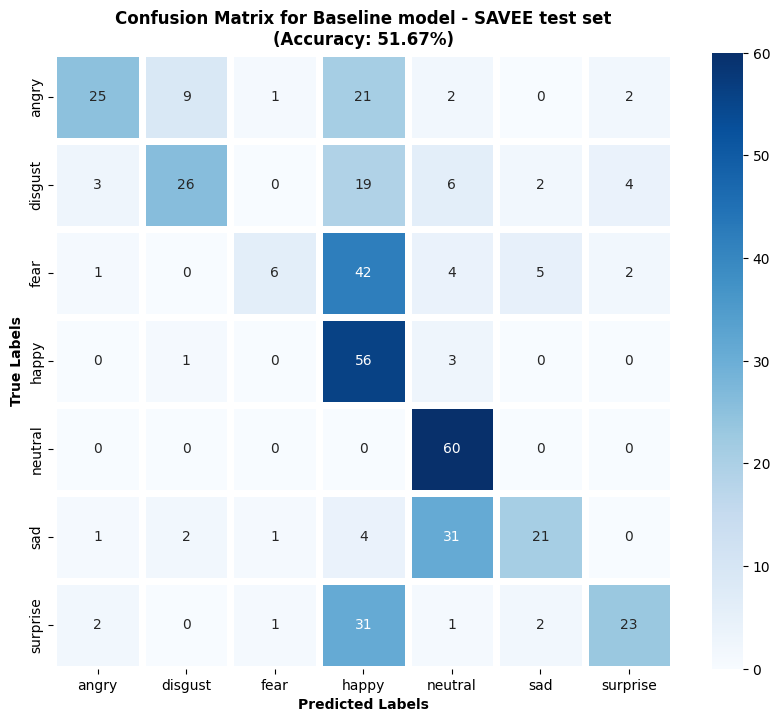


Loading model: Top 1 (SpecAugment)

Evaluating Top 1 (SpecAugment) model on SAVEE clean dataset...


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Testing SAVEE: 100%|██████████| 420/420 [00:17<00:00, 23.60it/s, loss=2.261, accuracy=0.481]



=== Results for SAVEE ===
Final accuracy: 48.0952%

Classification Report for Top 1 (SpecAugment) model on SAVEE test set:
              precision    recall  f1-score   support

       angry       0.56      0.62      0.59        60
     disgust       0.76      0.37      0.49        60
        fear       0.50      0.03      0.06        60
       happy       0.27      0.83      0.41        60
     neutral       0.75      0.95      0.84        60
         sad       0.58      0.35      0.44        60
    surprise       0.54      0.22      0.31        60

    accuracy                           0.48       420
   macro avg       0.57      0.48      0.45       420
weighted avg       0.57      0.48      0.45       420



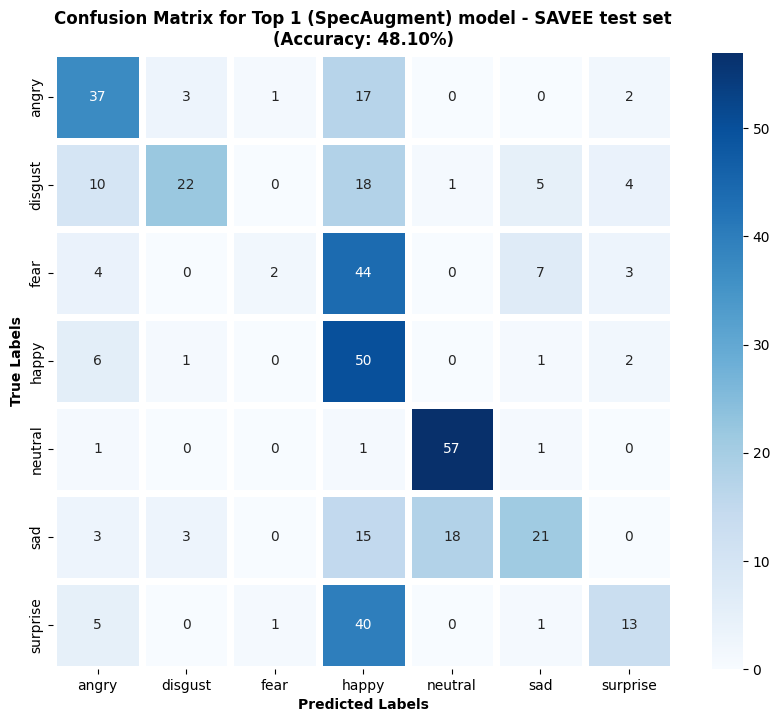


Loading model: Top 2 (SpecAugment + Time-stretch)

Evaluating Top 2 (SpecAugment + Time-stretch) model on SAVEE clean dataset...


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Testing SAVEE: 100%|██████████| 420/420 [00:17<00:00, 23.37it/s, loss=2.314, accuracy=0.483]



=== Results for SAVEE ===
Final accuracy: 48.3333%

Classification Report for Top 2 (SpecAugment + Time-stretch) model on SAVEE test set:
              precision    recall  f1-score   support

       angry       0.56      0.70      0.62        60
     disgust       0.83      0.33      0.48        60
        fear       0.57      0.07      0.12        60
       happy       0.28      0.88      0.42        60
     neutral       0.84      0.85      0.84        60
         sad       0.68      0.25      0.37        60
    surprise       0.46      0.30      0.36        60

    accuracy                           0.48       420
   macro avg       0.60      0.48      0.46       420
weighted avg       0.60      0.48      0.46       420



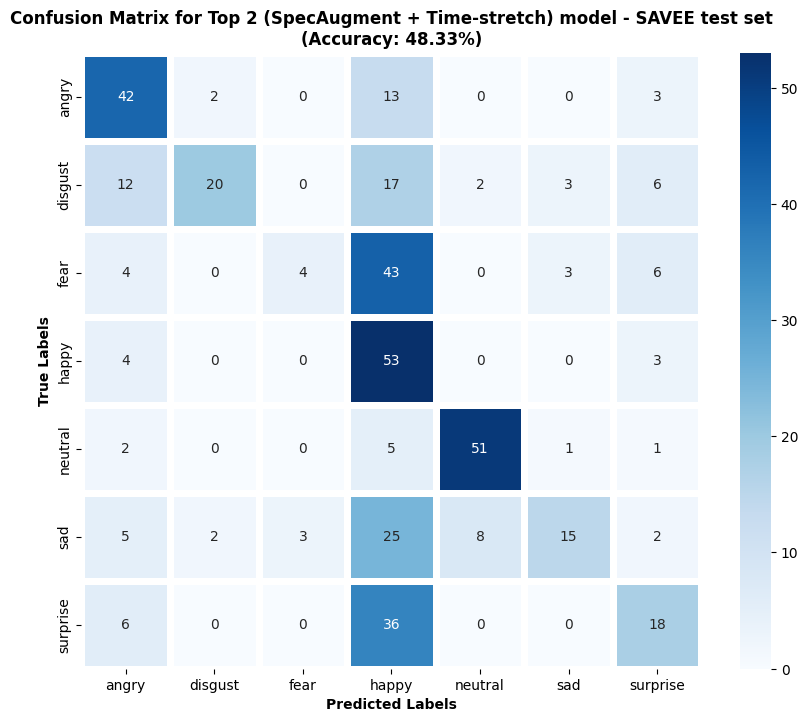

In [15]:
results_clean = {}

for model_info in models_paths:
    model_name = model_info["name"]
    model_path = model_info["path"]
    # Load model
    print(f"\nLoading model: {model_name}")
    model = HubertForSequenceClassification.from_pretrained(model_path)
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
    model.to(device)
    # Evaluate on test sets
    print(f"\nEvaluating {model_name} model on SAVEE clean dataset...")
    accuracy, df_record = evaluate_test_set(
        model,
        model_name,
        SAV_df,
        "SAVEE",
        device,
        feature_extractor
    )
